Current Time = 11:14:47
device=CPU, Hash=0
K =  1, T =  7, Run-time =    4.19 (sec.)

Plotting .... 


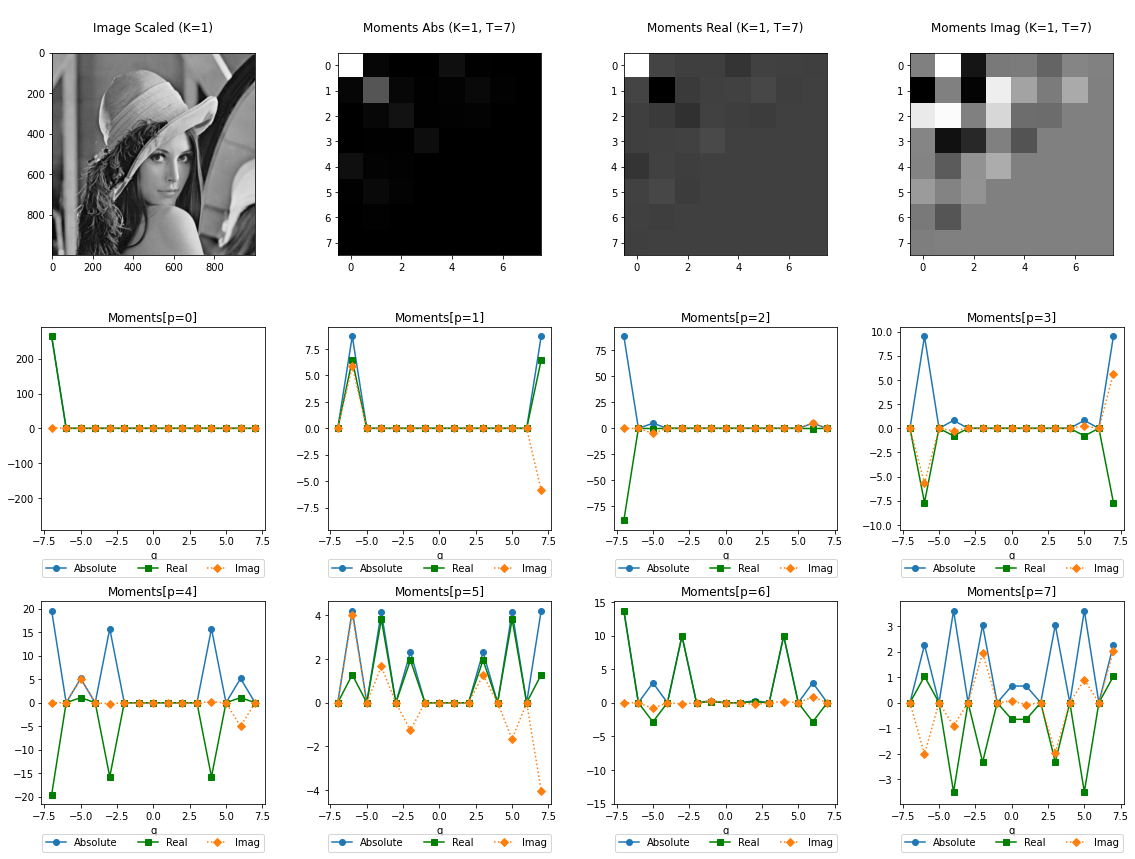

Done.
Wall time: 5.67 s


In [71]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 모멘트 특징 표시 

print_curr_time()

# 저니크 모멘트 함수 실험 
def test_zernike_features( imgfeature_info_infos, img, use_gpus, use_threads, use_hashs, Ks, Ts, **options ) : 
    
    if is_array( use_gpus ) :
        for use_gpu in use_gpus :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpu 
            options[ "use_thread"] = 0 
            options[ "use_hash" ] = 0 
            
            test_zernike_moments( feature_info, use_gpu, use_threads, use_hashs, Ks, Ts, **options )
        pass
    elif is_array( use_threads ) :
        for use_thread in use_threads :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpus 
            options[ "use_thread"] = use_thread  
            
            test_zernike_moments( feature_info, use_gpus, use_thread, use_hashs, Ks, Ts, **options )
        pass        
    elif is_array( use_hashs ) :
        for use_hash in use_hashs :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpus 
            options[ "use_thread"] = use_threads
            options[ "use_hash" ] = use_hash
            
            test_zernike_moments( feature_info, use_gpus, use_threads, use_hash, Ks, Ts, **options )
        pass 
    else :
        debug = get_option( "debug", **options )
        use_hash = get_option( "use_hash", ** options )
        use_thread = get_option( "use_thread", **options )
        use_gpu = get_option( "use_gpu", **options )
    
        device = "GPU" if use_gpu else "CPU"
        multi = "M-" if use_thread else ""
        
        if is_scalar( Ks ) :
            Ks = [ Ks ]
        pass
    
        if is_scalar( Ts ) :
            Ts = [ Ts ]
        pass 
        
        key = None
        for K in Ks :
                        
            if len( Ts ) > 1 : 
                key = f"{multi}{device}, Hash={use_hash}, K=({K})"
            else :
                key = f"{multi}{device}, Hash={use_hash}"
            pass    
        
            print( f"device={key}", flush=True) 
        
            options[ "hash" ] = {} 
            
            circle_type = "outer" 

            rho, theta, x, y, dx, dy, k, area = rho_theta( 1000*K, circle_type, **options ) 

            np = cupy if use_gpu else numpy

            #img_infos.append( { "title" : "Image Org", "img" : img } )
            
            img = cv.resize( img, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )
            
            if use_gpu : 
                img = np.array( img )
            pass
        
            feature_info [ "img_scaled" ] = { "title" : f"Image Scaled (K={K})", "img" : img }

            if debug : 
                print( "img shape= ", img.shape ) 
                print( line )
            pass
        
            for T in Ts :
                moments, run_time = calc_moments(T, img, rho, theta, dx, dy, **options )
                
                print( f"K = {K:2}, T = {T:2}, Run-time = {run_time:7.2f} (sec.)" )   
                
                feature_info[ "moments" ] = moments 
                feature_info[ "run_time" ] = run_time 
                feature_info[ "K" ] = K
                feature_info[ "T" ] = T
                
            pass # T
        pass # K
    pass
pass # test_zernike_features

def plot_moment_features( feature_info, **options ) : 

    print( "\nPlotting .... ")
    
    use_gpu = get_option( "use_gpu", **options )
    
    np = cupy if use_gpu else numpy  
    
    img_scaled = feature_info[ "img_scaled" ]
    
    K = feature_info[ "K" ]
    T = feature_info[ "T" ]
    
    moments = feature_info[ "moments" ]
    moments_disp = get_moments_disp( moments, **options )
    
    img_infos = []
    
    img_infos.append( img_scaled )
                
    img_infos.append( { "title" : f"Moments Abs (K={K}, T={T})", "img" : np.absolute( moments_disp.real ), "colorbar" : 0 } )
    img_infos.append( { "title" : f"Moments Real (K={K}, T={T})", "img" : moments_disp.real, "colorbar" : 0 } )
    img_infos.append( { "title" : f"Moments Imag (K={K}, T={T})", "img" : moments_disp.imag, "colorbar" : 0 } ) 
    
    # 서브 챠트 생성 
    col_cnt = 4
    
    n = len( img_infos ) + T + 1
    row_cnt = n // col_cnt
    if col_cnt*row_cnt < n :
        row_cnt += 1
    pass

    fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(4*col_cnt, 4*row_cnt) )
    charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
    chart_idx = 0 
    
    for img_info in img_infos : 
        t_img = img_info[ "img" ]
        title = img_info[ "title" ]
        title_low = title.lower()
        
        if "psnr" in img_info : 
            psnr = img_info[ "psnr"]
            
            title = f"\n{title}, PSNR={psnr:.2f}\n"
        else :
            title = f"\n{title}\n"
        pass
            
        colorbar = False 
        if "colorbar" in img_info :
            colorbar = img_info[ "colorbar" ]

        chart = charts[ chart_idx ] ; chart_idx += 1
        
        chart.set_title( title )
        
        pos = chart.imshow( cupy.asnumpy( t_img ) if options["use_gpu"] else t_img, cmap='gray' )
        colorbar and fig.colorbar(pos, ax=chart)
    pass  

    s = T
    x = numpy.arange( -s, s + 1 )
    
    for i, m in enumerate( moments ) : 
        chart = charts[ chart_idx ] ; chart_idx += 1
        
        y = m.real
        real = cupy.asnumpy( y ) if use_gpu else y        
        
        y = m.imag
        imag = cupy.asnumpy( y ) if use_gpu else y
        
        absolute = numpy.sqrt( real*real + imag*imag )
        max_y = numpy.max( absolute )
        chart.set_ylim( -max_y*1.1, max_y*1.1 )
                
        chart.plot( x, absolute, marker="o", label=f"Absolute", color="tab:blue" )  
        
        chart.plot( x, real,     marker="s", label=f"Real", linestyle="solid", color="g" ) 
        
        chart.plot( x, imag,     marker="D", label=f"Imag", linestyle="dotted", color="tab:orange" )
        
        title = f"Moments[p={i}]"
        chart.set_title( title )
        chart.set_xlabel( f"q" )
        
        chart.legend(loc="lower center", bbox_to_anchor=(0.5, -0.26), ncol=3 ) 
    pass

    # draw empty chart
    for chart_idx in range( chart_idx, len(charts) ) :
        chart = charts[ chart_idx ]
        chart.plot( [0,0], [0,0] )
        chart.set_axis_off()
    pass

    plt.tight_layout(); plt.show()
pass # plot_result
    
use_gpu    = 1
use_thread = 0
use_hash   = 0

K = 1 # 2

T = 7 # 10 

feature_info = {}

debug = 0

img = cv.imread( 'image/lenna.png', 0 ) 
            
test_zernike_features( feature_info, img, use_gpu, use_thread, use_hash, K, T, debug=debug ) 

plot_moment_features( feature_info, use_gpu=use_gpu )

print( "Done." )
